## Жерноклеев Дмитрий 
### Курсовая работа. 

### Импортируем необходимые модули

In [1]:
# Агентное моделирование в Python можно реализовывать 
# с использованием модуля Mesa
# !pip install mesa --quiet

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mesa import Agent, Model # будем работать с модулем mesa
from mesa.time import RandomActivation
from mesa.time import BaseScheduler
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner
from tqdm import tqdm
import itertools
import math as mt
%matplotlib inline
sns.set(style="darkgrid")

In [3]:
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint

### Подготовим данные по кредитным и депозитным портфелям для интересующих нас банков.

In [4]:
def df_prep_func(f_name: str):
    '''
    Функция подготовки датафреймов (на banki.ru они одноформатные).
    Данные берём за сентябрь, декабрь 2021, 
    т.к. нам важны концы последних двух кварталов.
    '''
    df = pd.read_csv(f_name, sep=';', index_col='Название банка', 
                                  skiprows=3, encoding='cp1251')
    df = df.iloc[:, [4, 5]]
    df.rename(columns={'Декабрь, 2021, тыс. рублей': '12.21, тыс.руб.', 
                        'Сентябрь, 2021, тыс. рублей': '09.21, тыс.руб.'}, inplace=True)
    # print(df.head(10))
    # print(df.shape)
    for col in df.columns: # преобразование колонок с числами к типу float
        df[col] = df[col].str.replace(' ', '')
        df[col] = df[col].str.replace(',', '.').astype(float)
    return df

In [5]:
df_firm_credits = df_prep_func('credits_firms.csv')
df_individ_credits = df_prep_func('credits_individ.csv')

In [6]:
def join_sum(df1, df2, bank_lst: list, portf_type='кред.'):
    '''
    Для получения кредитного/депозитного портфелей надо в обоих случаях
    получить данные из двух датафреймов, сджойнить (по индексу)
    и сложить соответствующие столбцы. portf_type - параметр 
    для правильного нейминга колонок результирующего датафрейма.
    '''
    df_joined = df1.join(df2, how='inner', lsuffix=' фирмы', rsuffix=' физ.лица')
    naming_str = portf_type + ' портф.'
    df_joined['Сент. 2021 ' + naming_str] = \
                        (df_joined['09.21, тыс.руб. фирмы'] 
                         + df_joined['09.21, тыс.руб. физ.лица']) * 1e3 / 1e12
    df_joined['Дек. 2021 ' + naming_str] = \
                        (df_joined['12.21, тыс.руб. фирмы'] 
                         + df_joined['12.21, тыс.руб. физ.лица']) * 1e3 / 1e12  # чтобы получить в триллионах  руб.
    return df_joined.iloc[:, [-2, -1]]\
                      .loc[bank_lst].sort_values('Дек. 2021 ' + naming_str, ascending=False)    

In [7]:
banks_of_interest_lst = [
                        'СберБанк', 'ВТБ', 'Газпромбанк', 'Альфа-Банк', 
                        'Россельхозбанк', 'Московский Кредитный Банк',
                        'Банк Открытие', 'Совкомбанк', 'Райффайзенбанк',
                        'Росбанк'
                        ]
df_cred_portf = join_sum(df_firm_credits, df_individ_credits, banks_of_interest_lst)
df_cred_portf

,Сент. 2021 кред. портф.,Дек. 2021 кред. портф.
Название банка,,
СберБанк,25.014377,26.456559
ВТБ,11.708385,11.766115
Газпромбанк,5.402313,5.556576
Альфа-Банк,3.439682,3.750167
Россельхозбанк,2.800246,2.864869
Московский Кредитный Банк,2.357967,2.584704
Банк Открытие,1.896928,2.021237
Совкомбанк,0.987160,1.133929
Райффайзенбанк,0.935499,0.990449


In [8]:
df_firm_deposits = df_prep_func('deposit_firms.csv')
df_individ_deposits = df_prep_func('deposit_individ.csv')
df_deposit_portf = join_sum(df_firm_deposits, df_individ_deposits, banks_of_interest_lst, 'депоз.')
df_deposit_portf

,Сент. 2021 депоз. портф.,Дек. 2021 депоз. портф.
Название банка,,
СберБанк,25.327964,25.910454
ВТБ,14.026752,14.128084
Газпромбанк,6.107606,6.620371
Альфа-Банк,3.792927,4.183137
Россельхозбанк,2.980584,3.116114
Московский Кредитный Банк,1.980591,2.117120
Банк Открытие,1.888624,2.046150
Совкомбанк,1.264465,1.379808
Райффайзенбанк,1.155217,1.162677


In [9]:
dep_rates_dict = {'Сент. 2021 депоз. ставка, %': [2.5, 4.4, 4.9, 3.5, 3.4, 5.6, 4.4, 3.4, 4.7, 4.5],
                  'Дек. 2021 депоз. ставка, %': [3.2, 4.5, 4.8, 3.6, 3.8, 5.5, 4.4, 4.1, 5.2, 5]}
df_deposit_rates = pd.DataFrame.from_dict(dep_rates_dict)
df_deposit_rates.index = banks_of_interest_lst
df_deposit_rates

,"Сент. 2021 депоз. ставка, %","Дек. 2021 депоз. ставка, %"
СберБанк,2.5,3.2
ВТБ,4.4,4.5
Газпромбанк,4.9,4.8
Альфа-Банк,3.5,3.6
Россельхозбанк,3.4,3.8
Московский Кредитный Банк,5.6,5.5
Банк Открытие,4.4,4.4
Совкомбанк,3.4,4.1
Райффайзенбанк,4.7,5.2
Росбанк,4.5,5.0


In [10]:
cred_rates_dict = {'Сент. 2021 кред. ставка, %': [11.2, 10.8, 10.2, 10.7, 11.6, 10.9, 12.1, 11.9, 9.8, 10.5],
                   'Дек. 2021 кред. ставка, %': [12.4, 11.6, 10.8, 11.3, 11.7, 11.8, 12.2, 13.1, 10.7, 10.4]}
df_credit_rates = pd.DataFrame.from_dict(cred_rates_dict)
df_credit_rates.index = banks_of_interest_lst
df_credit_rates

,"Сент. 2021 кред. ставка, %","Дек. 2021 кред. ставка, %"
СберБанк,11.2,12.4
ВТБ,10.8,11.6
Газпромбанк,10.2,10.8
Альфа-Банк,10.7,11.3
Россельхозбанк,11.6,11.7
Московский Кредитный Банк,10.9,11.8
Банк Открытие,12.1,12.2
Совкомбанк,11.9,13.1
Райффайзенбанк,9.8,10.7
Росбанк,10.5,10.4


### Отрисуем для лучшего представления обозначенную нами в работе функцию зависимости объема кредитования от средней ставки по рынку.

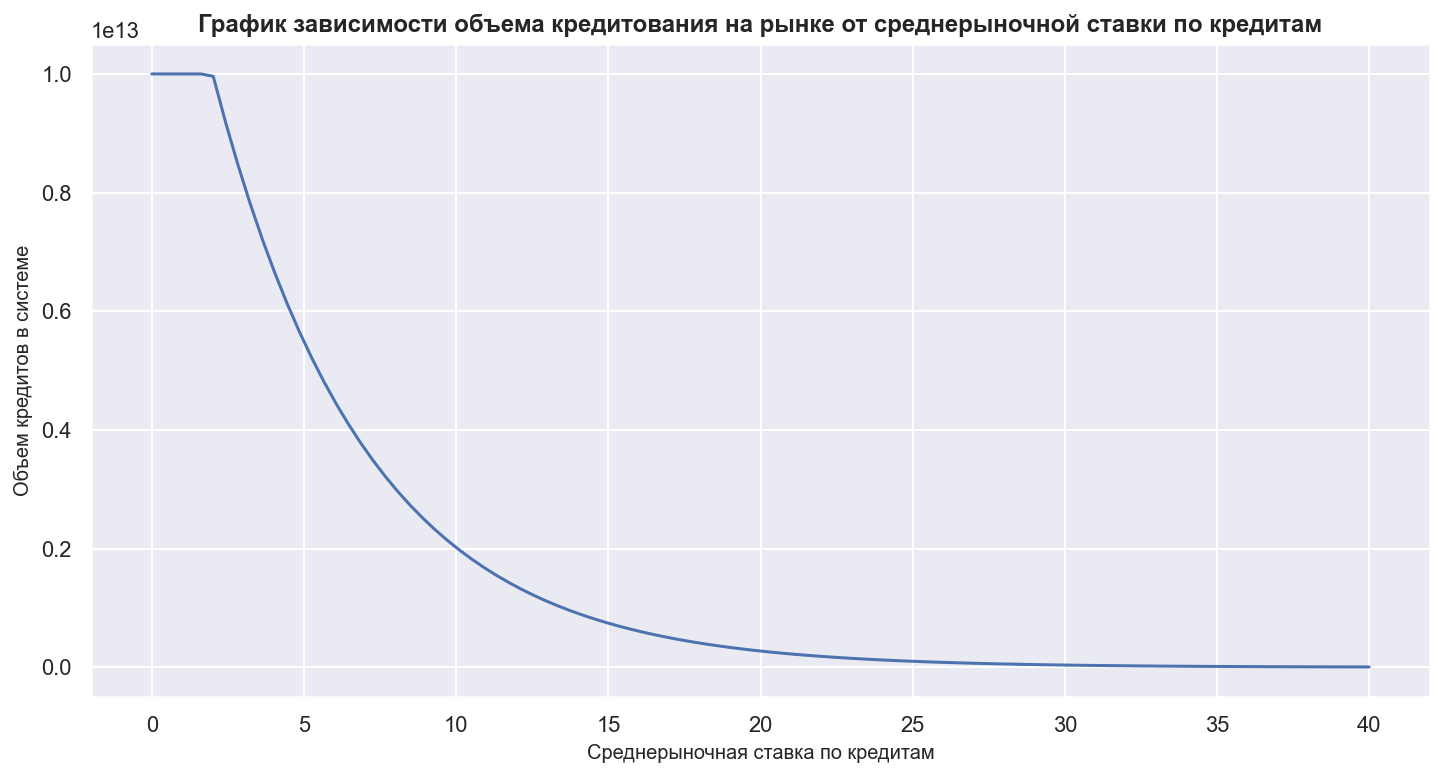

In [11]:
def f(x):
    elast = 0.2
    k = (10 ** 13) * (mt.e ** (2 * elast))
    return k * mt.exp(-elast * x) if x >=2 else 10 ** 13

x_arr = np.linspace(0, 40, 100)
y_arr = list(map(f, x_arr))

%config InlineBackend.figure_format = 'retina'
plt.figure(figsize=(12, 6))
plt.xlabel('Среднерыночная ставка по кредитам', fontsize=10)
plt.ylabel('Объем кредитов в системе', fontsize=10)
plt.title('График зависимости объема кредитования на рынке от среднерыночной ставки по кредитам', fontsize=12, weight='bold')
plt.plot(x_arr, y_arr)
plt.show()

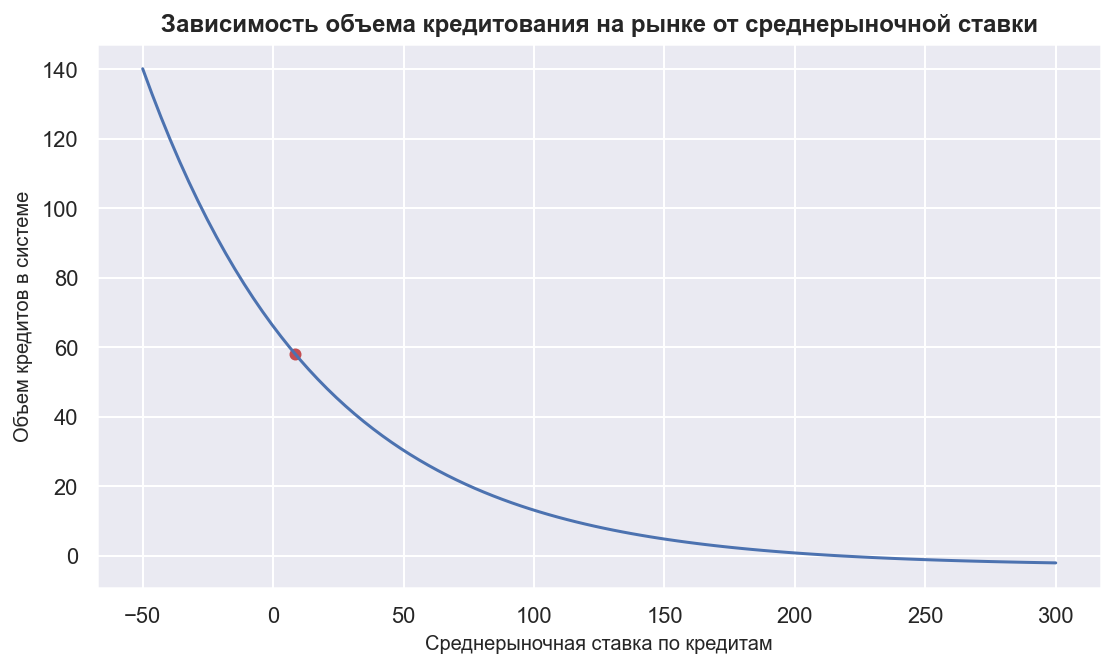

In [29]:
def exp_f_adj(x):
    return np.exp(4.23381792) * np.exp(-0.01459079 * x) - 2.9164431338609305

x_arr = np.linspace(-50, 300, 100)
y_arr = [exp_f_adj(x) for x in x_arr]

plt.figure(figsize=(9, 5))
plt.xlabel('Среднерыночная ставка по кредитам', fontsize=10)
plt.ylabel('Объем кредитов в системе', fontsize=10)
plt.title('Зависимость объема кредитования на рынке от среднерыночной ставки', fontsize=12, weight='bold')
plt.plot(x_arr, y_arr)
plt.scatter(x=8.5, y=58.01785506499999, s=25, c='r')
plt.show()

### Создадим класс для агентов нашей модели

In [13]:
class BankSysAgent(Agent):
    def __init__(self, unique_id, model, agent_type, name):
        super().__init__(unique_id, model)
        self.agent_type = agent_type # тип агента (ЦБ/банк/частный сектор(ЧС))
        self.name = name # имя (название) агента
        
    def BankProfit(self, Rates): # функция расчета BankProfit, к. подается оптимизатору scipy
        BankCreditRate, BankDepositRate = Rates
        mean_bank_credit_rate = (self.model.credit_rate_sum 
                                 - self.model.credit_rate_dict[self.name] 
                                 + BankCreditRate) / self.model.num_banks
        CreditVolume_t_1 = self.model.exp_f_adj(mean_bank_credit_rate)
        BankCreditRateSpread = BankCreditRate - (self.model.credit_rate_sum - \
                                                 self.model.credit_rate_dict[self.name]) / (self.model.num_banks - 1)
        CreditPortfolio_t_1 = 2 * self.model.sigm(-self.model.alpha_dict[self.name] * \
                                                    BankCreditRateSpread) * CreditVolume_t_1 * \
                                    (self.model.cred_portfolio_t_1_dict[self.name] / self.model.credit_vol_t_1)
        
        DepositVolume_t_1 = CreditVolume_t_1
        BankDepositRateSpread = BankDepositRate - (self.model.deposit_rate_sum - \
                                                   self.model.deposit_rate_dict[self.name]) / (self.model.num_banks - 1)
        DepositPortfolio_t_1 = 2 * self.model.sigm(self.model.alpha_dict[self.name] * \
                                                   BankDepositRateSpread) * DepositVolume_t_1 * \
                                    (self.model.deposit_portfolio_t_1_dict[self.name] / self.model.deposit_vol_t_1)
        
        CBMoney = DepositPortfolio_t_1 - CreditPortfolio_t_1
        BankProfit = - ((1 - self.model.default_rate) * self.model.rate_year_to_quart(BankCreditRate) * \
                    (CreditPortfolio_t_1  + self.model.cred_portfolio_t_1_dict[self.name]) / 2 - \
                    self.model.rate_year_to_quart(BankDepositRate) * \
                    (DepositPortfolio_t_1 + self.model.deposit_portfolio_t_1_dict[self.name]) / 2 + \
                    (CBMoney / 2) * (self.model.rate_year_to_quart(self.model.key_rate_t_1) + \
                                     0.1 * (-1 if CBMoney > 0 else 1)) + \
                    (self.model.CBMoney_t_1[self.name] / 2) * (self.model.rate_year_to_quart(key_rate_t_1) + \
                                                               0.1 * (-1 if self.model.CBMoney_t_1[self.name] > 0 else 1)))
        return BankProfit
    
    def step(self):
        if self.agent_type == 'CB': # шаг для ЦБ (первый раунд)
            self.model.key_rate_t += self.model.k * (self.model.rate_quart_to_year(self.model.delt_cred_vol) - \
                                                     self.model.target_inflat) # вычисление ключевой ставки 
            
        elif self.agent_type == 'Bank': # шаг для банков (второй раунд)
            bnds = ((1, 25), (1, 25))
            credit_rate, deposit_rate = minimize(self.BankProfit, (11, 11), 
                                                 bounds=bnds, method='SLSQP').x
            self.model.credit_rate_dict[self.name] = credit_rate
            self.model.deposit_rate_dict[self.name] = deposit_rate
            self.model.BankProfit_optimiz_dict[self.name] = self.BankProfit((credit_rate, deposit_rate))
            if self.name == self.model.ag_names_lst[-2]: # обновляем переменные, как описано в классе модели
                                                         # -2, т.к. нам нужен предпоследний агент (т.е. последний банк)
                                                         # фактически, это условие окончания второго раунда
                self.model.key_rate_t_1 = self.model.key_rate_t
                self.model.cred_portfolio_t_1_dict = dict(self.model.cred_portfolio_dict)
                self.model.credit_vol_t_1 = self.model.credit_vol
                self.model.deposit_portfolio_t_1_dict = dict(self.model.deposit_portfolio_dict)
                self.model.deposit_vol_t_1 = self.model.deposit_vol
                self.model.CBMoney_t_1 = dict(self.model.CBMoney)
            
        else: 
            self.model.credit_rate_sum, self.model.deposit_rate_sum = \
            sum(self.model.credit_rate_dict.values()), sum(self.model.deposit_rate_dict.values())
            mean_bank_credit_rate = self.model.credit_rate_sum / self.model.num_banks # считаем среднерыночную ставку
                                                                    # и объем взятых ЧС кредитов
            self.model.credit_vol = self.model.exp_f_adj(mean_bank_credit_rate)
            self.model.deposit_vol = self.model.credit_vol # полагаем объем депозитов = объему кредитов
            for a in self.model.schedule.agents:
                if a.agent_type == 'Bank':
                    bank_credit_rate_spread = self.model.credit_rate_dict[a.name] - \
                    (self.model.credit_rate_sum - self.model.credit_rate_dict[a.name]) / (self.model.num_banks - 1)
                    
                    self.model.cred_portfolio_dict[a.name] = 2 * self.model.sigm(-self.model.alpha_dict[a.name] * \
                                                                                  bank_credit_rate_spread) * \
                                                                                    self.model.credit_vol * \
                                                                                    (self.model.cred_portfolio_t_1_dict[a.name] / self.model.credit_vol_t_1)
                                         
                    bank_deposit_rate_spread = self.model.deposit_rate_dict[a.name] - \
                    (self.model.deposit_rate_sum - self.model.deposit_rate_dict[a.name]) / (self.model.num_banks - 1)
                    
                    self.model.deposit_portfolio_dict[a.name] = 2 * self.model.sigm(self.model.alpha_dict[a.name] * \
                                                                                    bank_deposit_rate_spread) * \
                                                                                    self.model.deposit_vol * \
                                                                                    (self.model.deposit_portfolio_t_1_dict[a.name] / self.model.deposit_vol_t_1)
                    
                    self.model.delt_cred_vol = (self.model.credit_vol - self.model.credit_vol_t_1) / self.model.credit_vol_t_1  
                    self.model.CBMoney[a.name] = self.model.deposit_portfolio_dict[a.name] - \
                                                    self.model.cred_portfolio_dict[a.name]


### Также создадим класс собственно для самой модели

In [14]:
class BankSysModel(Model):
    def __init__(self, key_rate_t_1, delt_cred_vol, alpha_dict, credit_rate_dict, credit_rate_sum, 
                 cred_portfolio_t_1_dict, cred_portfolio_dict, credit_vol_t_1, credit_vol, 
                 deposit_rate_dict, deposit_rate_sum, deposit_portfolio_t_1_dict, deposit_portfolio_dict, 
                 deposit_vol_t_1, deposit_vol, start_balance, start_credit_vol, start_credit_rates_mean,
                 banks_names, CBMoney_t_1, CBMoney, BankProfit_optimiz_dict,
                 default_rate=0.01, pelast=0.2, k=0.3, N=12, target_inflat=4):
        self.num_agents = N # общее число агентов
        self.num_banks = N - 2 # число банков (=общее число агентов - ЦБ - ЧС)
        self.key_rate_t_1 = key_rate_t_1 # предыдущая ключевая ставка (в %)<=обновл. в конце 2 раунда(key_rate_t_1 = key_rate_t)
        self.key_rate_t = key_rate_t_1 # текущая ключевая ставка (в %)
        self.k = k # коэффициент (для спреда) из формулы ключевой ставки 
        self.target_inflat = target_inflat # таргетная инфляция (в %)
        self.delt_cred_vol = delt_cred_vol # прирост портфеля за прошлый период <= обновл. в конце 3 раунда/начале 1 раунда
                                            # (credit_vol - credit_vol_t_1) / credit_vol_t_1
        self.default_rate = default_rate # доля дефолтных кредитов 
        self.pelast = pelast # эластичность частного сектора
        self.start_balance = start_balance # стартовый баланс системы
        self.start_credit_vol = credit_vol
        self.start_credit_rates_mean = start_credit_rates_mean
        
        self.alpha_dict = alpha_dict # словарь для альфа (коэффициентов надежности)
        self.credit_rate_dict =  credit_rate_dict # словарь для кредитных ставок (получаем значения во 2м раунде после оптимизации?)
        self.credit_rate_sum = credit_rate_sum
        self.cred_portfolio_t_1_dict = cred_portfolio_t_1_dict # словарь для объемов портфелей на t-1 
                                            # <=обновл. в конце 2 раунда(cred_portfolio_t_1_dict = cred_portfolio_dict)
                                            # нужен для СredPortfolio_(t-2) в BankProfit
        self.cred_portfolio_dict = cred_portfolio_dict #  словарь для объемов портфелей на t
        self.credit_vol_t_1 = credit_vol_t_1 # объем кредитов на t-1 <=обновл. в конце 2 раунда(credit_vol_t_1 = credit_vol) 
                                             # (нужен, чтобы посчитать CreditPortfolio при варьировании ставки на 2 шаге)
        self.credit_vol = credit_vol
        self.deposit_rate_dict =  deposit_rate_dict # словарь для депозитных ставок (получаем значения во 2м раунде после оптимизации?)
        self.deposit_rate_sum = deposit_rate_sum
        self.deposit_portfolio_t_1_dict = deposit_portfolio_t_1_dict # словарь для объемов депозитных портфелей на t-1 
                                            # <=обновл. в конце 2 раунда(deposit_portfolio_t_1_dict = deposit_portfolio_dict)
                                            # нужен для DepositPortfolio_(t-2) в BankProfit
        self.deposit_portfolio_dict = deposit_portfolio_dict # словарь для объемов депозитных портфелей на t
        self.deposit_vol_t_1 = deposit_vol_t_1 # объем депозитов на t-1 <=обновл. в конце 2 раунда(deposit_vol_t_1 = deposit_vol) 
                            # (нужен, чтобы посчитать DepositPortfolio при варьировании ставки на 2 шаге)
        self.deposit_vol = deposit_vol
        self.CBMoney_t_1 = CBMoney_t_1 # CBMoney в позапрошлом периоде (t-2 в формуле BankProfit)
                                       # <= обновляем в конце 2 раунда  (CBMoney_t_1 = CBMoney) и логируем?
        self.CBMoney = CBMoney # CBMoney в прошлом периоде (считаем в конце 3 раунда) 
        self.BankProfit_optimiz_dict = BankProfit_optimiz_dict # BankProfit, полученный при оптимизации во 2-м раунде 

        self.schedule = BaseScheduler(self) # добавим шедулер
        
        self.ag_names_lst = banks_names + ['Частный сектор']
        self.ag_names_lst.insert(0, 'Центральный Банк')
        ag_type_dict = {'Центральный Банк': 'CB',
                      'Частный сектор': 'PS'}
        
        # Инициализируем агентов и закидываем в шедулер
        for i, x in enumerate(self.ag_names_lst):
            if x in banks_names:  
                a = BankSysAgent(i, self, 'Bank', x)
                self.schedule.add(a)
            else:
                a = BankSysAgent(i, self, ag_type_dict[x], x)
                self.schedule.add(a)         
                
        self.datacollector = DataCollector(
            model_reporters={'key_rate': 'key_rate_t',
                             'delt_cred_vol': 'delt_cred_vol',
                            'credit_vol' : 'credit_vol'},
            tables={'CreditRates': banks_names, 
                   'DepositRates': banks_names,
                   'CreditPortfolios': banks_names,
                   'DepositPortfolios': banks_names,
                   'CBMoney': banks_names, 
                   'BankProfit_optimiz': banks_names}
        ) # для сбора данных по прогону модели
                
    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)
        self.datacollector.add_table_row('CreditRates', credit_rate_dict)
        self.datacollector.add_table_row('DepositRates', deposit_rate_dict)
        self.datacollector.add_table_row('CreditPortfolios', cred_portfolio_dict)
        self.datacollector.add_table_row('DepositPortfolios', deposit_portfolio_dict)
        self.datacollector.add_table_row('CBMoney', CBMoney)
        self.datacollector.add_table_row('BankProfit_optimiz', BankProfit_optimiz_dict)
    
    @staticmethod
    def rate_quart_to_year(rate):
        return ((1 + rate) ** 4 - 1) * 100
    
    @staticmethod
    def rate_year_to_quart(rate):
        return ((1 + rate / 100) ** .25 - 1) 
    
    @staticmethod
    def exp_f_adj(x):
        return np.exp(4.23381792) * np.exp(-0.01459079 * x) - 2.9164431338609305

    @staticmethod
    def sigm(x):
        return 1 / (1 + mt.exp(-x))

### Подготовим стартовые параметры для инициализации модели

In [15]:
key_rate_t_1 = 8.5 # ключевая ставка, объявленная в 
                   # декабре 2021 (конец прошлого квартала)
alpha_dict = dict(zip(banks_of_interest_lst, np.linspace(0.8, 0.6, 10)))
credit_rate_dict = df_credit_rates.iloc[:, 1].to_dict()
credit_rate_sum = round(df_credit_rates.iloc[:, 1].sum(), 2)
cred_portfolio_t_1_dict = df_cred_portf.iloc[:, 0].to_dict()
cred_portfolio_dict = df_cred_portf.iloc[:, 1].to_dict()
credit_vol_t_1 = df_cred_portf.iloc[:, 0].sum() # либо 1 вместо 0?
credit_vol = df_cred_portf.iloc[:, 1].sum()
start_credit_vol = credit_vol
start_credit_rates_mean = df_credit_rates.iloc[:, 1].mean()
delt_cred_vol = (credit_vol - credit_vol_t_1) / credit_vol_t_1
deposit_rate_dict = df_deposit_rates.iloc[:, 1].to_dict()
deposit_rate_sum = round(df_deposit_rates.iloc[:, 1].sum(), 2)
deposit_portfolio_t_1_dict = df_deposit_portf.iloc[:, 0].to_dict()
deposit_portfolio_dict = df_deposit_portf.iloc[:, 1].to_dict()
deposit_vol_t_1 = df_deposit_portf.iloc[:, 0].sum()
deposit_vol = df_deposit_portf.iloc[:, 1].sum()
start_balance = df_cred_portf.iloc[:, 1].sum() # стартовый баланс как 
                                               # сумма кредитных портфелей (в конце прошлого квартала декабря 2021)
banks_names = banks_of_interest_lst
CBMoney_t_1 = (df_deposit_portf.iloc[:, 0] - df_cred_portf.iloc[:, 0]).to_dict() # CBMoney в конце позапрошлого квартала
CBMoney = (df_deposit_portf.iloc[:, 1] - df_cred_portf.iloc[:, 1]).to_dict() # CBMoney в конце прошлого квартала
BankProfit_optimiz_dict = {k: 0 for k in banks_names}

In [15]:
# print((credit_vol - credit_vol_t_1) / credit_vol_t_1)
# print(deposit_vol_t_1 / 1e12)
# print(start_balance / 1e12)

In [49]:
# key_rate_t_1, delt_cred_vol, alpha_dict, credit_rate_dict, credit_rate_sum, \
# cred_portfolio_t_1_dict, cred_portfolio_dict, credit_vol_t_1, credit_vol, \
# deposit_rate_dict, deposit_rate_sum, deposit_portfolio_t_1_dict, deposit_portfolio_dict, \
# deposit_vol_t_1, deposit_vol, start_balance, start_credit_vol, start_credit_rates_mean,\
# banks_names, CBMoney_t_1, CBMoney, BankProfit_optimiz_dict

(8.5,
 0.04694409516342411,
 {'СберБанк': 0.8,
  'ВТБ': 0.7777777777777778,
  'Газпромбанк': 0.7555555555555555,
  'Альфа-Банк': 0.7333333333333334,
  'Россельхозбанк': 0.7111111111111111,
  'Московский Кредитный Банк': 0.6888888888888889,
  'Банк Открытие': 0.6666666666666666,
  'Совкомбанк': 0.6444444444444444,
  'Райффайзенбанк': 0.6222222222222222,
  'Росбанк': 0.6},
 {'СберБанк': 25.0,
  'ВТБ': 25.0,
  'Газпромбанк': 25.0,
  'Альфа-Банк': 25.0,
  'Россельхозбанк': 25.0,
  'Московский Кредитный Банк': 25.0,
  'Банк Открытие': 25.0,
  'Совкомбанк': 25.0,
  'Райффайзенбанк': 25.0,
  'Росбанк': 25.0},
 116.0,
 {'СберБанк': 25014376537000.0,
  'ВТБ': 11708384850000.0,
  'Газпромбанк': 5402313298000.0,
  'Альфа-Банк': 3439681924000.0,
  'Россельхозбанк': 2800246347000.0,
  'Московский Кредитный Банк': 2357967014000.0,
  'Банк Открытие': 1896927935000.0,
  'Совкомбанк': 987159778000.0,
  'Райффайзенбанк': 935499458000.0,
  'Росбанк': 873825962000.0},
 {'СберБанк': 82477418697.36333,
  'В

### Поправленная функция расчета общего объема кредитов в системе (с учетом нач. условия (точка))

In [15]:
k = 5 * mt.log(10 * start_balance / credit_vol) / (df_credit_rates.iloc[:, 1].mean() - 2)
c = 10 * start_balance * mt.e ** (2 * 0.2 * k)
credit_vol, k, c / 1e12

(58.01785506499999, 1.1992630692677324, 9.37335363185742e-10)

In [34]:
start_credit_rates_mean

11.6

In [35]:
def credit_vol_calc(x, elast, start_balance):
#     c = (10 * start_balance) * (mt.e ** (2 * elast))
#     return c * mt.exp(-elast * x) if x >= 2 else 10 * start_balance
    k = 5 * mt.log(10 * start_balance / credit_vol) / (df_credit_rates.iloc[:, 1].mean() - 2)
    c = 10 * start_balance * mt.e ** (2 * elast * k)
    return c * mt.exp(-elast * k * x) if x >= 2 else 10 * start_balance
# credit_vol_calc(11.6, 0.2, start_balance) 

58.017855064999935

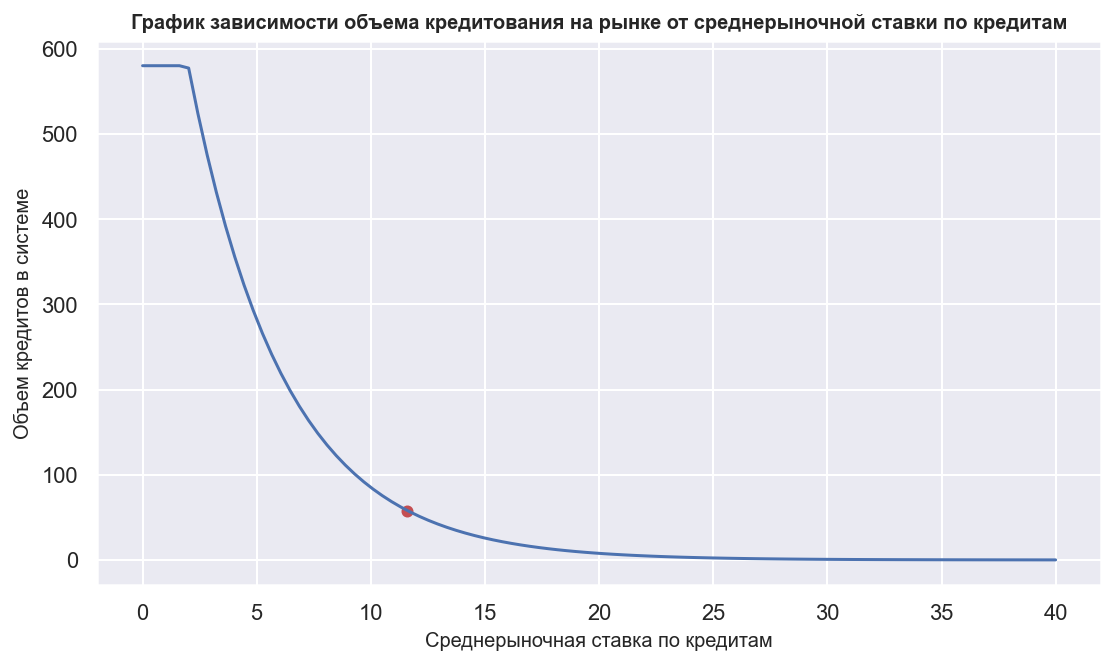

In [33]:
%config InlineBackend.figure_format = 'retina'
x_arr = np.linspace(0, 40, 100)
y_arr = [credit_vol_calc(x, 0.2, start_balance) for x in x_arr]
plt.figure(figsize=(9, 5))
plt.xlabel('Среднерыночная ставка по кредитам', fontsize=10)
plt.ylabel('Объем кредитов в системе', fontsize=10)
plt.title('График зависимости объема кредитования на рынке от среднерыночной ставки по кредитам', fontsize=10, weight='bold')
plt.scatter(x=df_credit_rates.iloc[:, 1].mean(), y=credit_vol, s=25, c='r')
plt.plot(x_arr, y_arr)
plt.show()

### Произведем запуск модели 

In [26]:
model = BankSysModel(key_rate_t_1, delt_cred_vol, alpha_dict, credit_rate_dict, credit_rate_sum, 
                     cred_portfolio_t_1_dict, cred_portfolio_dict, credit_vol_t_1, credit_vol, 
                     deposit_rate_dict, deposit_rate_sum, deposit_portfolio_t_1_dict, deposit_portfolio_dict, 
                     deposit_vol_t_1, deposit_vol, start_balance, start_credit_vol, start_credit_rates_mean,
                     banks_names, CBMoney_t_1, CBMoney, BankProfit_optimiz_dict,
                     default_rate=0.01, pelast=0.2, k=0.3, N=12, target_inflat=4)
for i in range(40):
    model.step()

In [27]:
model.key_rate_t

-34.35324420804208

In [28]:
CreditRates_data = model.datacollector.get_table_dataframe('CreditRates')
DepositRates_data = model.datacollector.get_table_dataframe('DepositRates')
CreditPortfolios_data = model.datacollector.get_table_dataframe('CreditPortfolios')
DepositPortfolios_data = model.datacollector.get_table_dataframe('DepositPortfolios')
CBMoney_data = model.datacollector.get_table_dataframe('CBMoney')
BankProfit_optimiz_data = model.datacollector.get_table_dataframe('BankProfit_optimiz')
other_vars = model.datacollector.get_model_vars_dataframe()

In [18]:
CreditPortfolios_data

,СберБанк,ВТБ,Газпромбанк,Альфа-Банк,Россельхозбанк,Московский Кредитный Банк,Банк Открытие,Совкомбанк,Райффайзенбанк,Росбанк
0,1.777666e+01,2.066667e+00,9.561721e-01,6.127578e+00,4.643970e+00,3.740044,0.410710,0.329847,2.691276e-01,0.216316
1,1.236161e+00,5.288486e+00,9.920375e-02,5.681203e-01,1.161872e+01,0.465715,0.051412,0.054239,6.825203e-01,0.539520
2,2.334480e+00,2.919339e+00,6.579635e-02,4.132894e-01,5.293140e+00,0.554047,0.096186,0.088545,1.018633e+00,1.130794
3,2.703548e+00,5.696445e-05,7.621807e-02,4.427305e-01,6.326485e+00,0.017638,0.087686,0.080031,1.156235e+00,1.275987
4,5.877892e-01,5.112105e-07,7.457262e-04,4.721025e-03,7.349733e-02,0.000223,0.019301,0.017614,1.884008e-02,0.022597
5,3.266459e-03,2.696323e-06,3.930372e-03,4.642700e-05,8.741381e-04,0.001173,0.101282,0.092282,4.789075e-04,0.048921
6,3.046354e-07,1.334874e-05,1.930176e-02,2.261140e-04,4.204827e-03,0.005613,0.480444,0.433704,2.147709e-03,0.197212
7,9.694045e-11,3.612612e-05,2.558579e-03,7.469662e-04,1.388890e-02,0.004663,0.012801,0.008214,2.812933e-03,0.650557
8,1.798239e-11,7.251508e-06,9.868761e-03,1.753817e-04,5.349261e-02,0.017944,0.000481,0.000233,9.700809e-04,2.489012
9,1.302307e-12,5.752504e-07,8.572771e-04,1.667739e-05,1.184590e-01,0.039689,0.001063,0.000515,1.441167e-04,0.127407


In [19]:
other_vars

,key_rate,delt_cred_vol,credit_vol
0,13.342526,-1.800680e-01,47.570693
1,-4.298323,2.824908e-01,61.008976
2,45.660973,2.817630e-01,78.199051
3,95.436213,-3.492158e-01,50.890709
4,69.617292,-8.898916e-01,5.603493
5,38.421701,1.648748e+00,14.842239
6,1483.892780,2.161124e+00,46.918164
7,4448.318909,6.525319e-01,77.533765
8,4640.847087,9.358980e-01,150.097460
9,5031.004986,1.156275e-01,167.452857


In [20]:
DepositRates_data

,СберБанк,ВТБ,Газпромбанк,Альфа-Банк,Россельхозбанк,Московский Кредитный Банк,Банк Открытие,Совкомбанк,Райффайзенбанк,Росбанк
0,3.316064,1.000000,1.000000,8.917908,9.693273,10.726929,1.000000,1.000000,1.000000,1.000000
1,1.002070,6.783801,1.000081,1.000000,7.942974,1.000000,1.000000,1.000000,7.638347,8.289144
2,7.341799,4.325686,3.598976,3.332564,2.743571,4.906764,8.494651,7.656719,10.770454,10.298235
3,4.758387,1.000000,5.446552,4.505663,7.733638,1.000000,11.000000,11.000000,8.702593,7.745867
4,9.249725,9.877204,11.354944,8.383096,8.884991,9.787466,11.000000,11.000000,8.896826,9.023104
5,1.000000,11.000000,11.000000,15.497733,7.925763,11.000000,11.000000,11.000000,1.000000,20.368524
6,1.000000,11.000000,11.000000,11.000000,10.851297,11.000000,11.000000,11.000000,8.470999,6.965857
7,11.593866,25.000000,25.000000,16.647470,16.880615,18.121887,17.185981,17.288370,11.000000,18.476195
8,11.000000,11.000000,25.000000,11.000000,25.000000,25.000000,25.000000,25.000000,11.000000,25.000000
9,11.000000,11.000000,11.000000,11.000000,25.000000,25.000000,25.000000,25.000000,11.000000,25.000000


In [21]:
def res_plot(titles_lst, *dfs):
    %config InlineBackend.figure_format = 'retina'
    fig, ax = plt.subplots(len(dfs), 1, figsize=(14, 30))
    for i, df in enumerate(dfs):
        df.plot(ax=ax[i])
        ax[i].set_xlabel('Номер шага', fontsize=10)   
        ax[i].set_title('Динамика ' + titles_lst[i], fontsize=12, weight='bold')
        # ax[i].legend(loc='lower left')
    fig.subplots_adjust(left=0, right=1, bottom=0.01, top=0.99,
                        hspace=0.2, wspace=0.1)
    plt.show() 

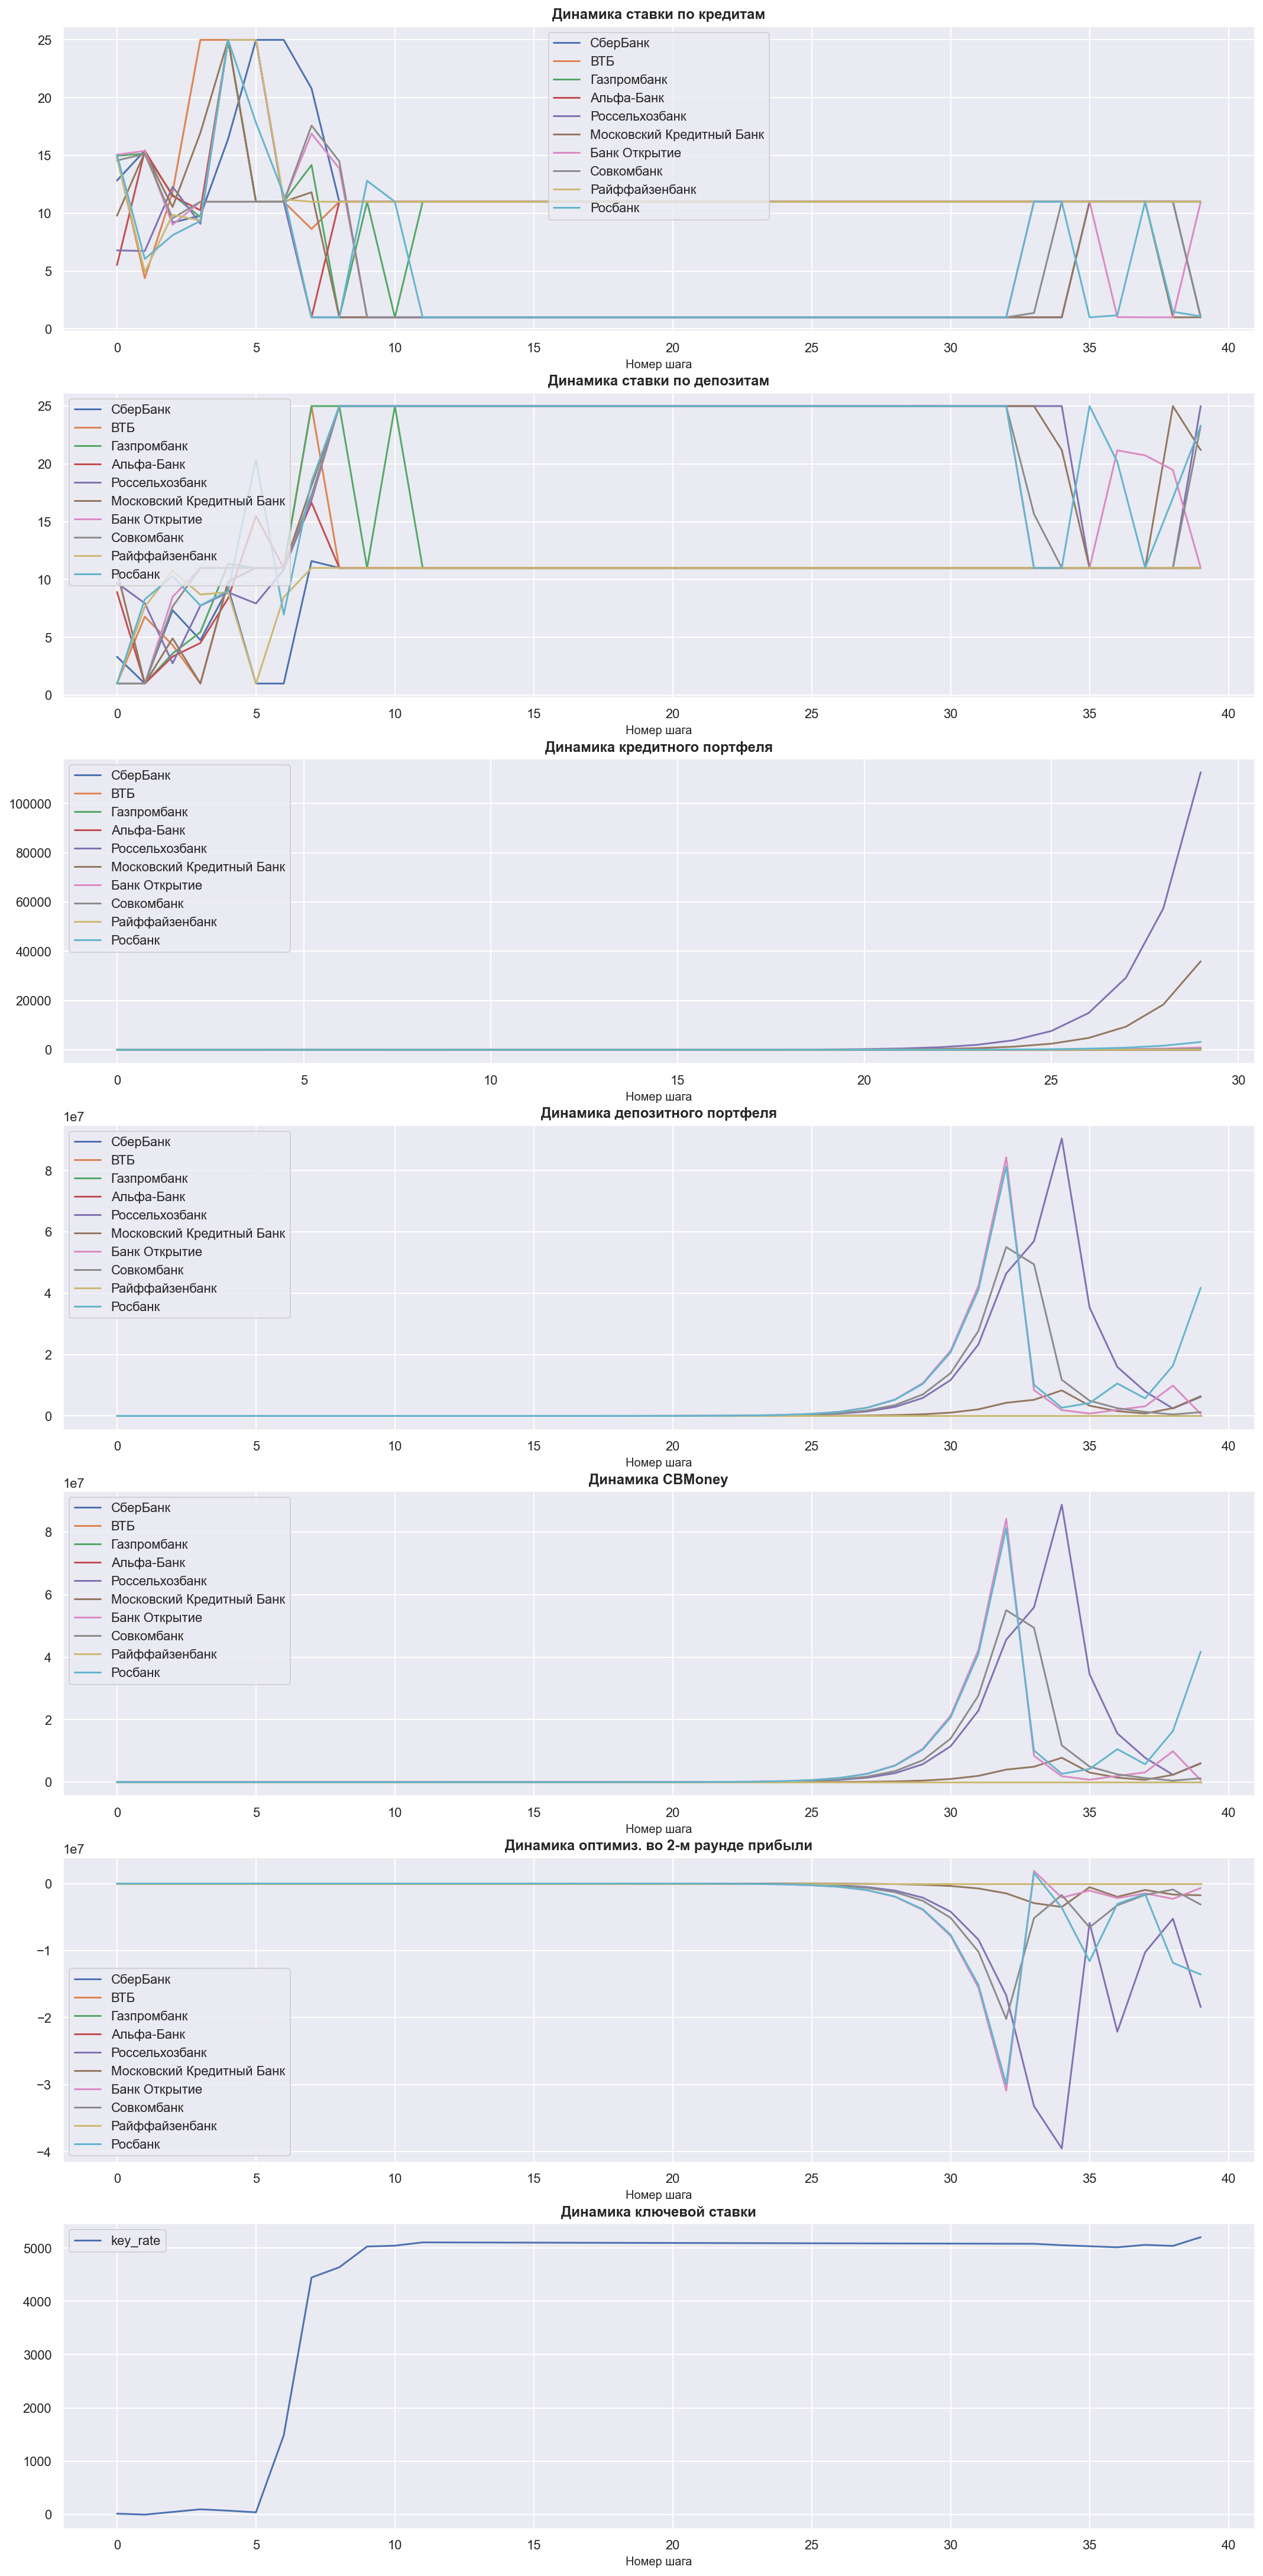

In [22]:
titles_lst = ['ставки по кредитам', 'ставки по депозитам', 'кредитного портфеля', 
              'депозитного портфеля', 'CBMoney', 'оптимиз. во 2-м раунде прибыли',
              'ключевой ставки']
res_plot(titles_lst, CreditRates_data, DepositRates_data,
         CreditPortfolios_data.iloc[:30, :], DepositPortfolios_data, 
         CBMoney_data, BankProfit_optimiz_data, other_vars[['key_rate']]) #,

In [16]:
model = BankSysModel(key_rate_t_1, delt_cred_vol, alpha_dict, credit_rate_dict, credit_rate_sum, 
                     cred_portfolio_t_1_dict, cred_portfolio_dict, credit_vol_t_1, credit_vol, 
                     deposit_rate_dict, deposit_rate_sum, deposit_portfolio_t_1_dict, deposit_portfolio_dict, 
                     deposit_vol_t_1, deposit_vol, start_balance, start_credit_vol, start_credit_rates_mean,
                     banks_names, CBMoney_t_1, CBMoney, BankProfit_optimiz_dict,
                     default_rate=0.01, pelast=0.2, k=0.3, N=12, target_inflat=4)
for i in range(40):
    model.step()

In [17]:
model.key_rate_t

-34.35324420804208

In [18]:
CreditRates_data = model.datacollector.get_table_dataframe('CreditRates')
DepositRates_data = model.datacollector.get_table_dataframe('DepositRates')
CreditPortfolios_data = model.datacollector.get_table_dataframe('CreditPortfolios')
DepositPortfolios_data = model.datacollector.get_table_dataframe('DepositPortfolios')
CBMoney_data = model.datacollector.get_table_dataframe('CBMoney')
BankProfit_optimiz_data = model.datacollector.get_table_dataframe('BankProfit_optimiz')
other_vars = model.datacollector.get_model_vars_dataframe()

In [19]:
CreditPortfolios_data

,СберБанк,ВТБ,Газпромбанк,Альфа-Банк,Россельхозбанк,Московский Кредитный Банк,Банк Открытие,Совкомбанк,Райффайзенбанк,Росбанк
0,8.810751,4.931072e+00,2.193485,6.943697e+00,1.130371,0.947219,3.603307e+00,0.642401,0.520518,0.417792
1,6.122583,5.012479e+00,1.631173,3.406913e+00,0.721841,1.351363,1.741124e+00,0.339053,0.268653,0.839043
2,3.797828,2.925057e+00,0.959413,1.766936e+00,0.378623,2.546203,3.348768e+00,0.650395,0.050916,0.281681
3,0.264258,1.669411e-01,1.492137,1.388732e-01,0.732909,0.451672,3.113929e+00,0.891447,0.082743,0.552759
4,0.000050,3.459773e-02,2.604947,3.659014e-02,1.266473,0.246023,1.239898e+00,1.634408,0.146544,1.009011
5,0.000067,3.563794e-02,2.707688,3.900494e-02,0.952345,0.290767,5.785060e-02,1.082032,0.273885,1.324175
6,0.000131,6.925329e-02,2.092371,7.539884e-02,1.263853,0.025565,1.718694e-02,0.002235,0.519368,0.539531
7,0.000257,1.354024e-01,0.001165,1.465679e-01,0.482640,0.002916,3.303748e-02,0.000854,0.519898,0.594122
8,0.000487,2.550380e-01,0.000658,2.728394e-01,0.000148,0.005355,6.023794e-02,0.001544,0.244475,0.136861
9,0.000773,4.016954e-01,0.001029,4.227818e-01,0.000200,0.008230,9.093637e-02,0.002310,0.001249,0.057719


In [20]:
other_vars

,key_rate,delt_cred_vol,credit_vol
0,13.342526,-7.280100e-02,53.794097
1,4.314945,1.246891e-02,54.464851
2,4.639433,1.268973e-02,55.155996
3,4.991432,-2.550108e-04,55.141930
4,3.760843,-4.235964e-02,52.806138
5,-2.208357,-5.131697e-03,52.535153
6,-4.019437,-6.858190e-03,52.174857
7,-6.033992,2.514746e-03,52.306063
8,-6.931082,2.163849e-02,53.437887
9,-5.448961,2.265183e-02,54.648353


In [21]:
DepositRates_data

,СберБанк,ВТБ,Газпромбанк,Альфа-Банк,Россельхозбанк,Московский Кредитный Банк,Банк Открытие,Совкомбанк,Райффайзенбанк,Росбанк
0,1.000000,1.000000,1.000000,8.936618,1.000000,1.000771,7.735002,1.000000,1.000592,1.003473
1,2.720013,2.905713,2.330235,1.896679,2.214524,10.893909,1.740765,1.528656,1.491430,7.124480
2,3.185517,3.112018,2.911866,2.919768,2.700200,10.163275,9.883066,9.932187,1.000000,1.918654
3,1.000124,1.000009,7.046081,1.000000,10.055738,1.000000,4.904466,10.930487,8.349740,8.948701
4,1.000000,1.000000,10.930478,1.000000,8.378699,1.013957,1.000000,10.816473,11.000000,10.654912
5,10.760522,10.575941,8.344190,10.621165,6.094425,10.645335,1.000000,4.087230,11.000000,8.173077
6,11.000000,11.000000,8.370230,11.000000,11.838801,11.076633,11.449206,1.000000,11.000000,6.276904
7,11.000000,11.000000,1.000000,11.000000,12.422892,11.470630,11.000000,12.101409,13.391148,13.185225
8,11.000000,11.000000,13.228337,11.000000,1.000000,11.000000,11.000000,11.000000,13.622571,13.063447
9,11.000000,11.000000,11.000000,11.000000,11.575042,6.688594,11.000000,11.000000,1.000000,12.183372


In [22]:
def res_plot(titles_lst, *dfs):
    %config InlineBackend.figure_format = 'retina'
    fig, ax = plt.subplots(len(dfs), 1, figsize=(14, 30))
    for i, df in enumerate(dfs):
        df.plot(ax=ax[i])
        ax[i].set_xlabel('Номер шага', fontsize=10)   
        ax[i].set_title('Динамика ' + titles_lst[i], fontsize=12, weight='bold')
        # ax[i].legend(loc='lower left')
    fig.subplots_adjust(left=0, right=1, bottom=0.01, top=0.99,
                        hspace=0.2, wspace=0.1)
    plt.show() 

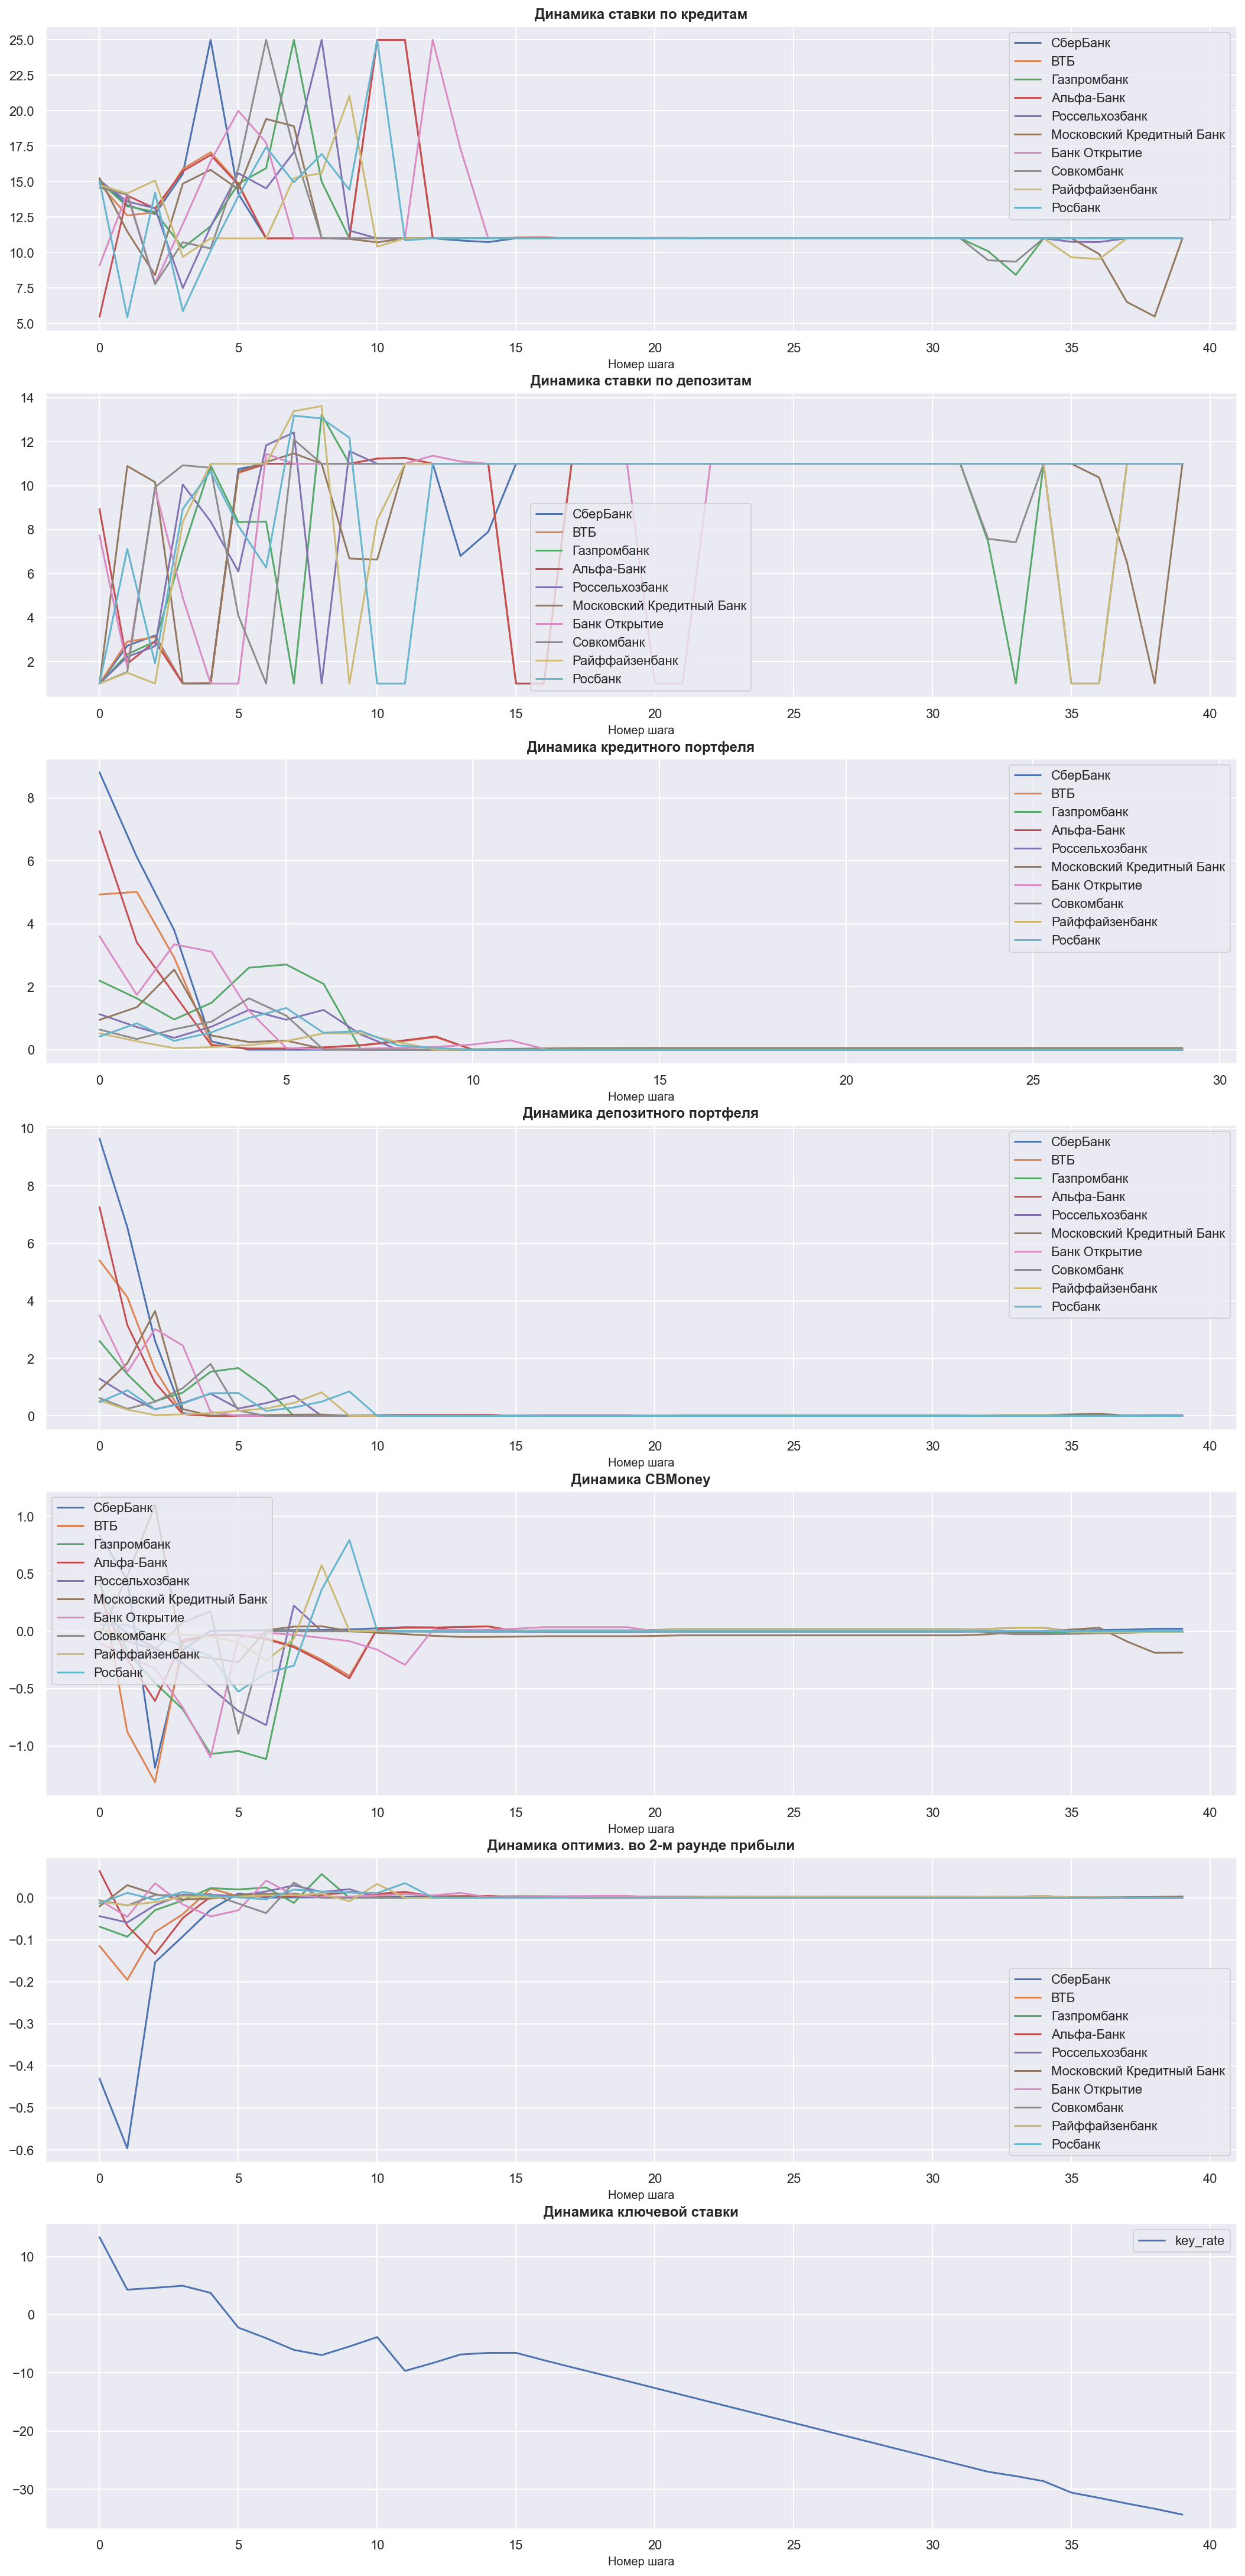

In [23]:
titles_lst = ['ставки по кредитам', 'ставки по депозитам', 'кредитного портфеля', 
              'депозитного портфеля', 'CBMoney', 'оптимиз. во 2-м раунде прибыли',
              'ключевой ставки']
res_plot(titles_lst, CreditRates_data, DepositRates_data,
         CreditPortfolios_data.iloc[:30, :], DepositPortfolios_data, 
         CBMoney_data, BankProfit_optimiz_data, other_vars[['key_rate']]) #,

### Отрисуем зависимость объема кредитного/депозитного портфелей банка от спреда ставки банка по кредитам/депозитам, соответственно

In [94]:
def sigm(x):
    return 1 / (1 + mt.exp(-x))

In [85]:
def CreditPortfolio(BankCreditRateSpread, alpha, bank_name):
    return 2 * sigm(-alpha[bank_name] * BankCreditRateSpread) * credit_vol * \
(cred_portfolio_t_1_dict[bank_name] / credit_vol_t_1)

In [86]:
def DepositPortfolio(BankDepositRateSpread, alpha, bank_name):
    return 2 * sigm(alpha[bank_name] * BankDepositRateSpread) * deposit_vol * \
(deposit_portfolio_t_1_dict[bank_name] / deposit_vol_t_1)        

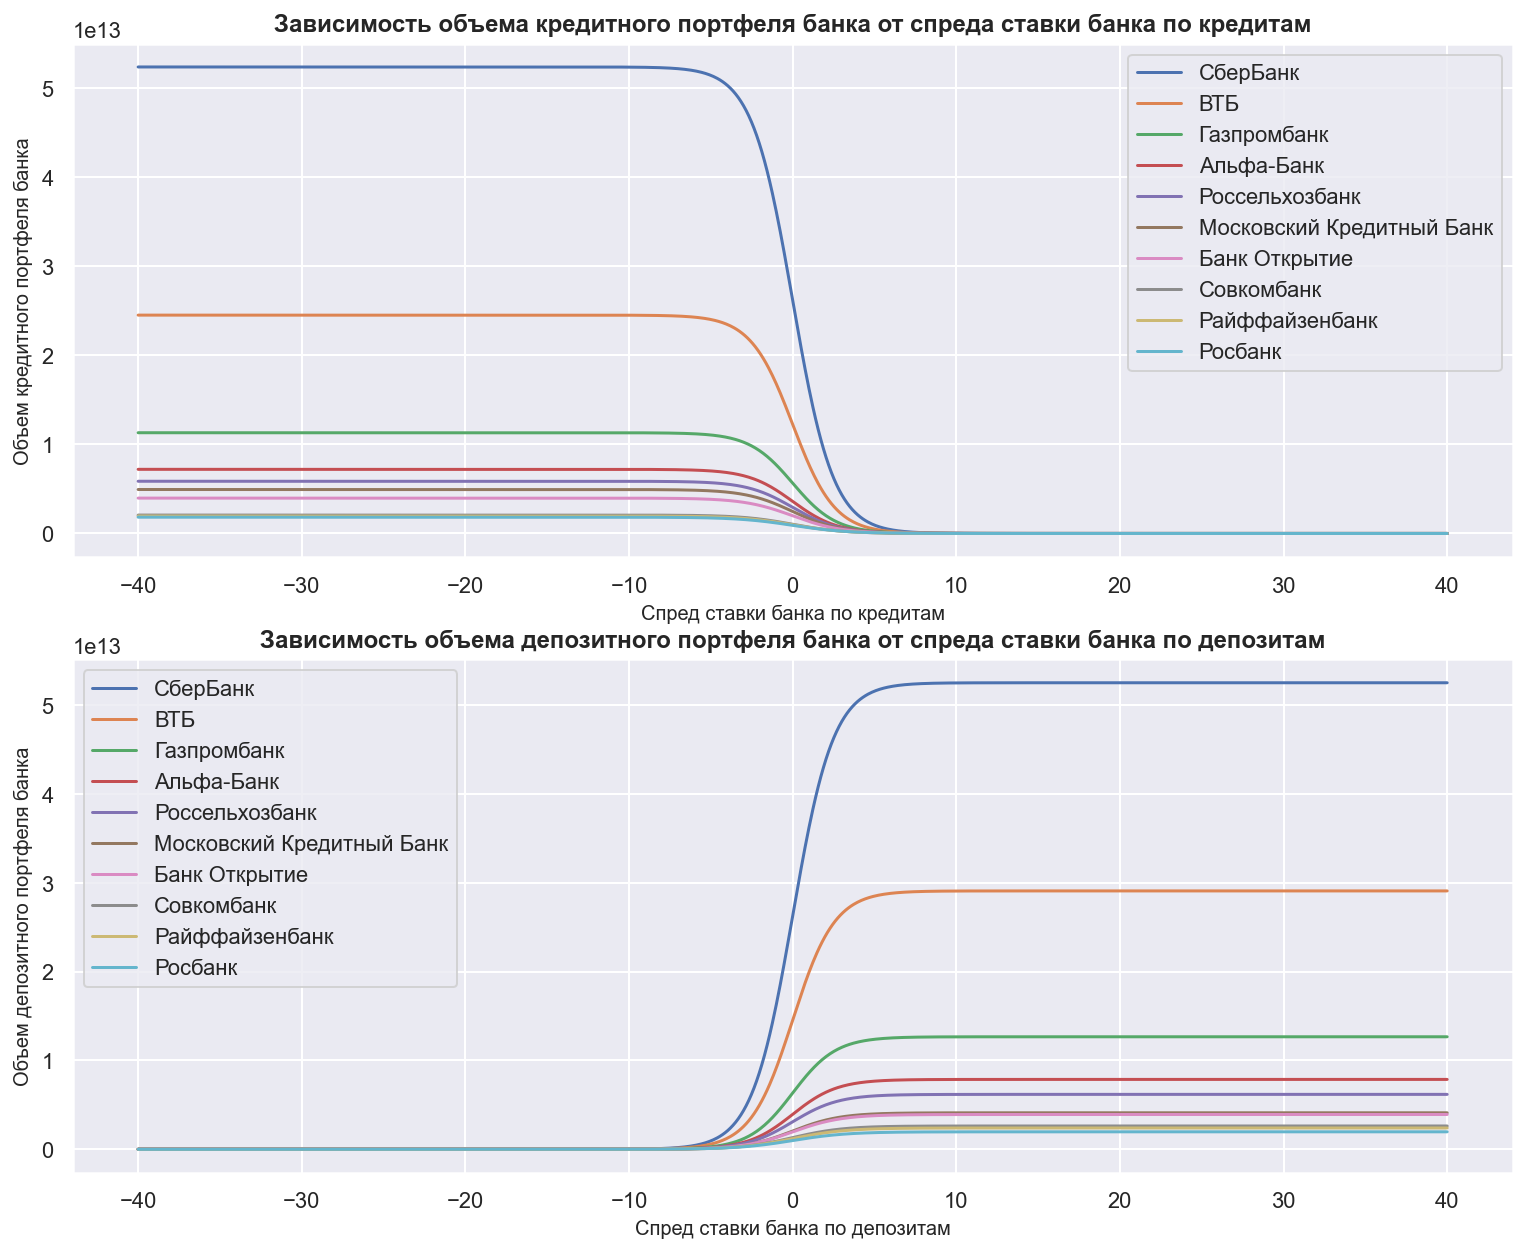

In [93]:
%config InlineBackend.figure_format = 'retina'
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
for b in banks_of_interest_lst:
    x_arr = np.linspace(-40, 40, 1000)
    y_arr0 = [CreditPortfolio(x, alpha_dict, b) for x in x_arr]
    ax[0].set_xlabel('Спред ставки банка по кредитам', fontsize=10)
    ax[0].set_ylabel('Объем кредитного портфеля банка', fontsize=10)
    ax[0].set_title('Зависимость объема кредитного портфеля банка от спреда ставки банка по кредитам',
                    fontsize=12, weight='bold')
    ax[0].plot(x_arr, y_arr0, label=b)
    ax[0].legend()
    
    y_arr1 = [DepositPortfolio(x, alpha_dict, b) for x in x_arr]
    ax[1].set_xlabel('Спред ставки банка по депозитам', fontsize=10)
    ax[1].set_ylabel('Объем депозитного портфеля банка', fontsize=10)
    ax[1].set_title('Зависимость объема депозитного портфеля банка от спреда ставки банка по депозитам', 
                    fontsize=12, weight='bold')
    ax[1].plot(x_arr, y_arr1, label=b)
    ax[1].legend()
    
fig.subplots_adjust(left=0, right=1, bottom=0.01, top=0.99,
                    wspace=0.1)
plt.show()

### Результаты старых запусков

In [73]:
key_rate

,key_rate
0,13.342526
1,18.185052
2,23.027578
3,27.870104
4,32.712631
5,37.555157
6,42.397683
7,47.240209
8,52.082735
9,56.925261


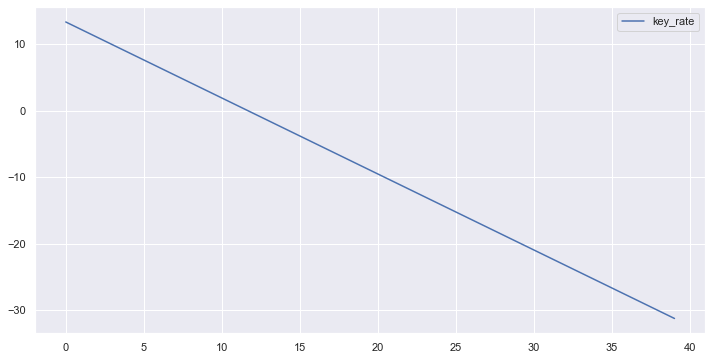

In [37]:
key_rate.plot(figsize=(12,6))
plt.show()

In [20]:
CreditRates_data

,СберБанк,ВТБ,Газпромбанк,Альфа-Банк,Россельхозбанк,Московский Кредитный Банк,Банк Открытие,Совкомбанк,Райффайзенбанк,Росбанк
0,15.226242,15.252237,15.453463,15.488340,15.546949,15.804872,15.708084,15.451560,15.835654,16.090782
1,19.705801,19.682455,19.743175,19.856949,19.951133,20.156867,20.160994,20.179616,20.264164,20.374073
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,11.000000,10.999989,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
4,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,10.999999,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.527022,1.217289,1.000000,1.000000,1.000000
7,10.255689,10.255689,10.255689,10.255689,10.255689,10.782711,10.472978,10.255689,10.255689,10.255689
8,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
9,11.000000,10.999147,11.000000,11.000000,10.996067,11.000000,11.000000,11.000000,11.000000,11.000000


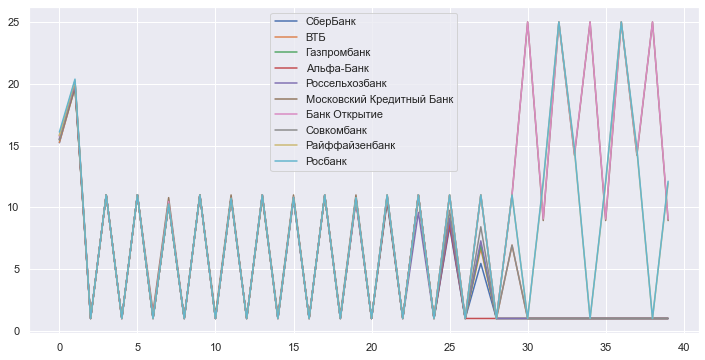

In [21]:
CreditRates_data.plot(figsize=(12,6))
plt.show()

In [22]:
DepositRates_data

,СберБанк,ВТБ,Газпромбанк,Альфа-Банк,Россельхозбанк,Московский Кредитный Банк,Банк Открытие,Совкомбанк,Райффайзенбанк,Росбанк
0,25.0,25.0,25.0,25.0,25.0,25.0,25.000000,25.0,25.000000,25.000000
1,25.0,25.0,25.0,25.0,25.0,25.0,25.000000,25.0,25.000000,25.000000
2,25.0,25.0,25.0,25.0,25.0,25.0,25.000000,25.0,25.000000,25.000000
3,25.0,25.0,25.0,25.0,25.0,11.0,11.000000,25.0,11.000000,11.000000
4,25.0,25.0,25.0,25.0,25.0,25.0,25.000000,25.0,25.000000,25.000000
5,25.0,25.0,25.0,25.0,25.0,11.0,11.000000,25.0,11.000000,11.000000
6,25.0,25.0,25.0,25.0,25.0,25.0,25.000000,25.0,25.000000,25.000000
7,25.0,25.0,25.0,25.0,25.0,11.0,11.737834,25.0,12.041991,12.042005
8,25.0,25.0,25.0,25.0,25.0,25.0,25.000000,25.0,25.000000,25.000000
9,25.0,25.0,25.0,25.0,25.0,11.0,11.000000,25.0,11.000000,11.000000


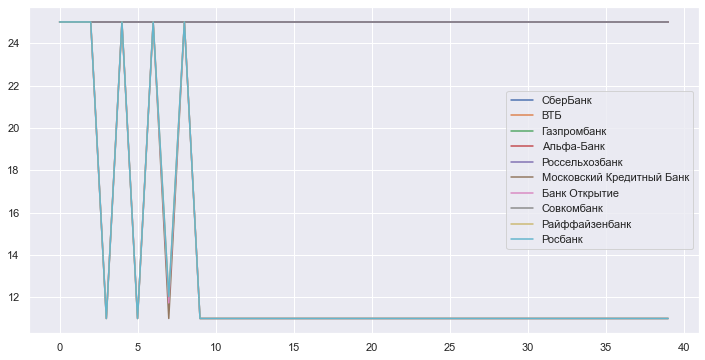

In [23]:
DepositRates_data.plot(figsize=(12,6))
plt.show()

In [24]:
CreditPortfolios_data

,СберБанк,ВТБ,Газпромбанк,Альфа-Банк,Россельхозбанк,Московский Кредитный Банк,Банк Открытие,Совкомбанк,Райффайзенбанк,Росбанк
0,-3.264075e+13,-1.478061e+13,-7.694211e+12,-5.279777e+12,-4.135607e+12,-4.106295e+12,-3.097370e+12,-1.582571e+12,-1.577161e+12,-1.527939e+12
1,2.828972e+13,1.271806e+13,6.843942e+12,4.956297e+12,4.043491e+12,4.340741e+12,3.273239e+12,1.679956e+12,1.716713e+12,1.713704e+12
2,-2.828972e+13,-1.271806e+13,-6.843942e+12,-4.956297e+12,-4.043491e+12,-4.340741e+12,-3.273239e+12,-1.679956e+12,-1.716713e+12,-1.713704e+12
3,2.828973e+13,1.271800e+13,6.843945e+12,4.956299e+12,4.043493e+12,4.340743e+12,3.273241e+12,1.679957e+12,1.716714e+12,1.713705e+12
4,-2.828973e+13,-1.271800e+13,-6.843945e+12,-4.956299e+12,-4.043493e+12,-4.340743e+12,-3.273241e+12,-1.679957e+12,-1.716714e+12,-1.713705e+12
5,2.828972e+13,1.271800e+13,6.843945e+12,4.956299e+12,4.043493e+12,4.340743e+12,3.273241e+12,1.679957e+12,1.716714e+12,1.713705e+12
6,-2.735423e+13,-1.230911e+13,-6.630191e+12,-4.806051e+12,-3.924629e+12,-5.085189e+12,-3.446268e+12,-1.635199e+12,-1.672554e+12,-1.671196e+12
7,2.644967e+13,1.191337e+13,6.423114e+12,4.660358e+12,3.809259e+12,5.957309e+12,3.628442e+12,1.591635e+12,1.629530e+12,1.629741e+12
8,-2.644967e+13,-1.191337e+13,-6.423114e+12,-4.660358e+12,-3.809259e+12,-5.957309e+12,-3.628442e+12,-1.591635e+12,-1.629530e+12,-1.629741e+12
9,2.645529e+13,1.191144e+13,6.424404e+12,4.661267e+12,3.804061e+12,5.958401e+12,3.629085e+12,1.591907e+12,1.629799e+12,1.630001e+12


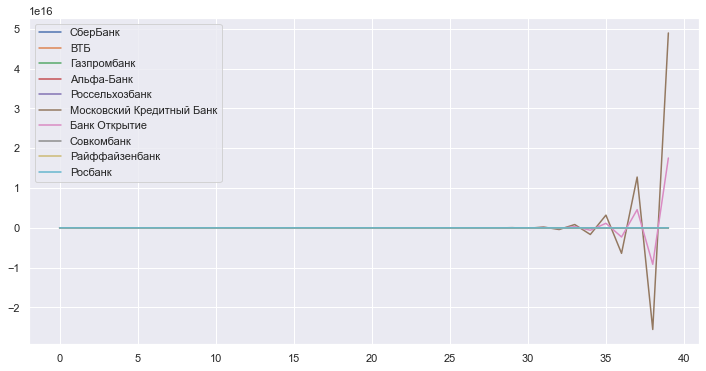

In [25]:
CreditPortfolios_data.plot(figsize=(12,6))
plt.show()

In [26]:
DepositPortfolios_data

,СберБанк,ВТБ,Газпромбанк,Альфа-Банк,Россельхозбанк,Московский Кредитный Банк,Банк Открытие,Совкомбанк,Райффайзенбанк,Росбанк
0,3.573801e+13,1.948671e+13,9.131405e+12,5.769755e+12,4.298021e+12,2.920120e+12,2.822232e+12,1.903154e+12,1.603668e+12,1.385144e+12
1,3.573801e+13,1.948671e+13,9.131405e+12,5.769755e+12,4.298021e+12,2.920120e+12,2.822232e+12,1.903154e+12,1.603668e+12,1.385144e+12
2,3.573801e+13,1.948671e+13,9.131405e+12,5.769755e+12,4.298021e+12,2.920120e+12,2.822232e+12,1.903154e+12,1.603668e+12,1.385144e+12
3,7.098696e+13,3.866752e+13,1.809840e+13,1.142038e+13,8.494299e+12,9.405417e+09,1.118111e+10,3.738508e+12,9.609841e+09,1.020641e+10
4,7.098696e+13,3.866752e+13,1.809840e+13,1.142038e+13,8.494299e+12,9.405417e+09,1.118111e+10,3.738508e+12,9.609841e+09,1.020641e+10
5,1.410025e+14,7.672806e+13,3.587095e+13,2.260497e+13,1.678752e+13,3.029391e+07,4.429726e+07,7.343830e+12,5.758615e+07,7.520570e+07
6,1.410025e+14,7.672806e+13,3.587095e+13,2.260497e+13,1.678752e+13,3.029391e+07,4.429726e+07,7.343830e+12,5.758615e+07,7.520570e+07
7,2.795302e+14,1.519223e+14,7.092539e+13,4.462413e+13,3.307984e+13,7.864381e+04,2.457573e+05,1.436873e+13,5.823126e+05,9.174148e+05
8,2.795302e+14,1.519223e+14,7.092539e+13,4.462413e+13,3.307984e+13,7.864381e+04,2.457573e+05,1.436873e+13,5.823126e+05,9.174148e+05
9,5.552352e+14,3.014599e+14,1.405738e+14,8.832691e+13,6.537661e+13,2.533039e+02,9.736401e+02,2.822556e+13,3.489458e+03,6.759953e+03


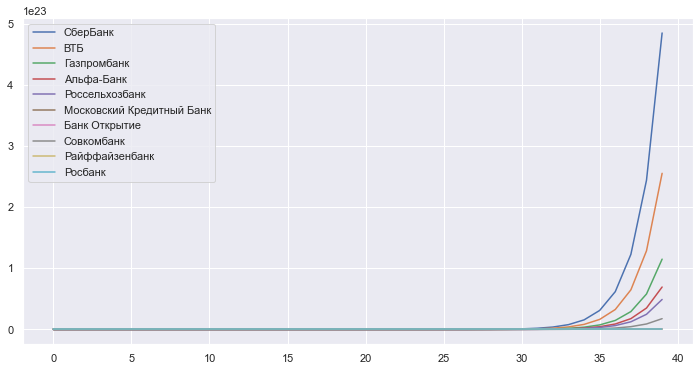

In [27]:
DepositPortfolios_data.plot(figsize=(12,6))
plt.show()